# YouTube Channel Analysis PJT

## In this project, I will be analyzing the official YouTube channel of the K-pop group LE SSERAFIM.

# 1. Introduction
## 1.1 Background
Le sserafim is a popular K-pop girl group that debuted in May 2022. The group is known for creating many entertaining contents, especially YouTube content on their official YouTube channel. Nowadays, YouTube contents including music videos play a big part in establishing yourself as an artist, and K-pop artists in general are the front-runners in effectively using YouTube content to boost their popularity. The most famous example is BTS, who created a great bond with fans ("army") through their clever use of social media content. Le sserafim from Source Music (which is a subsidiary of HYBE) is following in the footsteps of BTS. I thought it would be interesting to gain some insights into their YouTube content performance. 

I want to analyze the performance of their content in general and gain some insights into what type of content resonates well with their fans. Then, I want to suggest some content ideas that might do well considering the past performance history. The scope of the project will be limited to the analysis of the Le sserafim channel only, and won't compare other Kpop group's channels or comparable YouTube channels. 

## 1.2 Objectives
In this project, I will focus on learning the followings:

- Get familiar with YouTube API, and use the API to gather YouTube channel data
- Analyze video metrics to find out what type of content are popular among fans:
    - What type of content gets the most views?
    - What type of content has the most engagement among the fans?
    - What are some contents that didn't perform well, and why?
    - How does the video performance of a certain type of content change over time?
- Utilize NLP techniques to gain some insights on fan reaction:
    - Explore the top 100 comments of videos to explore fan reactions
    - Is there a meaningful difference in comment reactions by content types?
    - Is there any content idea that can come from the comment sections?
- Come up with some content ideas with the insights gained from the above analysis

## 1.3 Project process
1. Get the channel video data, and comments data from LE SSERAFIM channel using YouTube Data API v3.
2. Preprocess data and engineer new features
3. Perform exploratory data analysis
4. Conclusions

## 1.4 Dataset
### Data Source
For this project, I obtained the dataset myself by utilizing YouTube Data API v3. 

### Data Limitation
The data is a real-world dataset, suitable for research purposes. However, considering the API quota limit of 10,000 units per day, I only analyzed the Le sserafim channel and not other comparable channels. It can be interesting to compare the performance of Le sserafim channel with other Kpop groups' channels, which could be the next step of this project. 

Also, comments are limited to 100 top-level comments per video due to the same API quota limit. The video metric is also a total metric, meaning it contains the total views and total engagement metrics which makes it harder to compare each video in fair standing because older videos naturally will have more views. It would be nice to have 7-day or 14-day video metrics, but the API does not have such options. 

### Ethics of data source
According to the Youtube API guide, the usage of YouTube API is free and open to anyone who created API KEY. As long as the API user abides by the YouTube API quota limit, there is no issue in using YouTube API to get data. Also, the data itself is public data that can be obtained from the YouTube channel, so there is no privacy issue involved with the data source.


In [1]:
# Import basic libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import API related libraries 
from googleapiclient.discovery import build
from IPython.display import JSON

# Import API KEY from the config file
import sys
sys.path.append('/Users/minguyeo/Documents/coding/pythonPJT/config')
import yt_api_key as api

# Enable Korean Font
from matplotlib import font_manager, rc
import platform

if platform.system() == 'Windows':
# For windows user
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else:    
# For mac user
    rc('font', family='AppleGothic')

plt.rcParams['axes.unicode_minus'] = False

#NLP libraries (Word cloud package import)
from wordcloud import WordCloud
from wordcloud import STOPWORDS


# 2. Data collection with YouTube Data API v3

First, I created an API key from the google cloud platform(GCP) console, and enabled YouTube Data API v3 for my account. I saved the API_KEY in the separate config directory, so I can import the API_KEY without showing the key in the notebook. Then, I checked the channel id of Le sserafim YouTube channel from the channe url, and created `get_channel_stats`, `get_video_ids`,`get_video_stats`,`get_comments_in_videos` functions to collect video statistics and top 100 comments of all the videos in the channel via the API. 

In [3]:
# Build API service
youtube = build('youtube', 'v3', developerKey=api.API_KEY)

# Get the channel id of Le sserafim channel
channel_id = 'UCs-QBT4qkj_YiQw1ZntDO3g'

In [5]:
# Define custom functions to get data from API
def get_channel_stats(youtube, channel_id):
    """
    Get the channel name, current subscriber count, total view count, and playlist id
    """
    request = youtube.channels().list(
        part="snippet,contentDetails,statistics",
        id=channel_id)
    response = request.execute()
    
    all_data = []
    
    for item in response['items']:
        data = {'channel_name': item['snippet']['title'],
                'subscribers': item['statistics']['subscriberCount'],
                'total_views': item['statistics']['viewCount'],
                'video_count': item['statistics']['videoCount'],
                'playlist_id': item['contentDetails']['relatedPlaylists']['uploads']
               }
        
        all_data.append(data)
    
    return pd.DataFrame(all_data)


def get_video_ids(youtube, playlist_id):
    """
    Get all the video ids using the playlist id of the channel
    """    
    video_ids = []
    
    request = youtube.playlistItems().list(
        part="snippet,contentDetails",
        playlistId= playlist_id,
        maxResults = 50
    )

    response = request.execute()
    
    for item in response['items']:
        video_ids.append(item['contentDetails']['videoId'])
        
    next_page_token = response.get('nextPageToken')
    
    while next_page_token is not None:
        request = youtube.playlistItems().list(
            part="snippet,contentDetails",
            playlistId= playlist_id,
            maxResults = 50,
            pageToken = next_page_token            
            )

        response = request.execute()
        
        for item in response['items']:
            video_ids.append(item['contentDetails']['videoId'])

        next_page_token = response.get('nextPageToken')

    return video_ids


# Get the video stats

def get_video_stats(youtube, video_ids):
    """
    Get video stats of the video ids
    """
    all_video_stat = []
    
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
                part="snippet,contentDetails,statistics",
                id=','.join(video_ids[i:i+50])
            )
        response = request.execute()

        for video in response['items']:
            stats = {'snippet': ['publishedAt', 'title', 'description', 'tags'],
                     'contentDetails': ['duration'],
                     'statistics': ['viewCount','likeCount','favoriteCount','commentCount']}

            video_stat ={}
            video_stat['video_id'] = video['id']

            for i in stats.keys():
                for k in stats[i]:
                    try:
                        video_stat[k] = video[i][k]
                    except:
                        video_stat[k] = None

            all_video_stat.append(video_stat)
        
    return pd.DataFrame(all_video_stat)


def get_comments_in_videos(youtube, video_ids):
    """
    Get top 100 comments for each the video id
    """
    
    all_comments = []
    
    for video_id in video_ids:
        try:
            request = youtube.commentThreads().list(
                part="snippet,replies",
                videoId=video_id,
                maxResults = 100
            )

            response = request.execute()

            for comment in response['items']:
                comments = {}
                comments['video_id'] = comment['snippet']['videoId']

                toplevel = {'snippet': ['authorDisplayName', 'textOriginal', 'likeCount', 'publishedAt']}

                for i in toplevel['snippet']:
                    comments[i] = comment['snippet']['topLevelComment']['snippet'][i]

                comments['reply_count'] = comment['snippet']['totalReplyCount']

                all_comments.append(comments)
                
        except:
            print('No comment available for ' + video_id)
            
    return pd.DataFrame(all_comments)

### Get the Le sserafim YouTube channel statistics

Using the defined `get_channel_stats` function with Le sseafim's channel id, we can get the channel information of Le sserafim channel. We have to save the playlist_id in particular, in order to download all the videos' video id in the channel.

In [6]:
# Get the channel stats
channel_info = get_channel_stats(youtube, channel_id)

In [7]:
channel_info

,channel_name,subscribers,total_views,video_count,playlist_id
0,LE SSERAFIM,2620000,713242804,318,UUs-QBT4qkj_YiQw1ZntDO3g


### Get Le sserafim channel's video statistics

Get all the videos' video id with `get_video_ids` function, and put the list in the dataframe.

In [21]:
# Get the video ids from the LESSERAFIM Channel
playlist_id = channel_info['playlist_id'].iloc[0]
# Get the video ids for the Le sserafim channel
video_ids = get_video_ids(youtube, playlist_id)
# Create a dataframe with the video_ids
video_id_list = pd.DataFrame(video_ids, columns=['video_id'])

Get the video statistics of all the video ids in the list by using `get_video_stats` function.

In [37]:
# Get the video stats for all the videos of Le sserafim channel
video_stat = get_video_stats(youtube, video_ids)

Get the top 100 comments for each video using `get_comments_in_videos` function.

In [ ]:
# Get top 100 comments of each video
comments = get_comments_in_videos(youtube, video_ids)

Save all the data gathered from the API to csv files, so that we do not have to call API requests everytime we need the original copy of data, and use the csv file as a reference.

In [115]:
# Get video id list into csv file
video_id_list.to_csv('LS_video_ids.csv', index=False)
# Save video stat data into csv file
video_stat.to_csv('video_stat.csv', index=False)
# Save comments data in csv file
comments.to_csv('comments.csv', index=False)

Read in the csv file to perform EDA.

In [2]:
# Read video id list csv file
video_id_list = pd.read_csv('LS_video_ids.csv')
# Get video_stat csv file data
video_stat = pd.read_csv('video_stat.csv')
# Get comments csv file
comments = pd.read_csv('comments.csv')

# 3. Preprocess data and engineer new features

We need to perform some preprocessing before we dive into analysis. 
- First, I will drop columns if they are irrelevant for the project, and change the column names to conveninent alternatives for each dataframe.
- Then, I will check for null or empty values and fill in these values or drop values if necessary. 
- Next, I will reformat some data values, especially time related columns (`publishedAt`, `duration`), and change data types to appropriate ones.

Examine the head of each dataframe.

In [3]:
video_stat.head()

,video_id,publishedAt,title,description,tags,duration,viewCount,likeCount,favoriteCount,commentCount
0,yTKQQZsVeTs,2023-03-22T12:00:01Z,"르카페☕️️ OPEN❣️ 첫 손님(feat. 채채즈), 어서오세요😊 #LE_SSER...",#LE_SSERAFIM #르세라핌 공식 채널\n#LE_SSERAFIM #르세라핌 O...,NaN,PT44S,8688,2038,0,0
1,xQJmEiZXFYE,2023-03-22T11:00:01Z,[LENIVERSE] EP.17 LE CAFÉ 1편,#르세라핌 #르니버스 #EP17\n\n#LE_SSERAFIM #르세라핌 공식 채널\...,"['LE SSERAFIM', '르세라핌']",PT31M6S,70309,10581,0,735
2,T5qURRwoLHo,2023-03-21T13:00:30Z,😉🫶🫡👋😚 @ FEARNADA #LE_SSERAFIM #르세라핌 #shorts,NaN,NaN,PT34S,104685,17962,0,200
3,rp3BqWM1cC8,2023-03-21T12:00:02Z,[EPISODE] LE SSERAFIM(르세라핌) @ GMO SONIC 2023,#LE_SSERAFIM #르세라핌 공식 채널\n#LE_SSERAFIM #르세라핌 O...,"['LE SSERAFIM', '르세라핌']",PT13M52S,142752,11623,0,401
4,0LZiW_ut1jA,2023-03-19T11:45:00Z,Love you twice FEARNOT ! 🫰#LE_SSERAFIM #르세라핌 #...,#LE_SSERAFIM #르세라핌 공식 채널\n#LE_SSERAFIM #르세라핌 O...,NaN,PT10S,90006,13686,0,171


In [4]:
comments.head()

,video_id,authorDisplayName,textOriginal,likeCount,publishedAt,reply_count
0,_D78-pgvnzg,ˊo̴̶̷̤.̮o̴̶̷̤ˋ,컨셉이 다르다보니 춤선이 해린은 통통튀는 춤선이고 은채는 딱 깔끔한 춤선인데 둘 다...,7,2022-11-11T23:41:15Z,0
1,_D78-pgvnzg,Win Cup,두 그룹이 콜레보도 언젠가 가능할듯!,7,2022-11-11T23:32:58Z,0
2,_D78-pgvnzg,Laconist JH,확실히 뉴진스는 발을 많이 쓰는 편이고 르세라핌은 상체모션을 더 많이 쓰는 것같은데...,1,2022-11-11T23:13:41Z,0
3,_D78-pgvnzg,Jhon Mendes,Haerin 6 member fits him perfectly,6,2022-11-11T22:44:47Z,0
4,_D78-pgvnzg,두밧두,은채는파워풀하고 해린은고급지면서 파워풀해,1,2022-11-11T22:42:59Z,0


### Drop Columns

I wanted to drop unnecessary columns first. For video_stat, I noticed that `tags` only have Le SSERAFIM in English and Korean. `favoriteCount` column values were all 0, so no reason to keep the column. <br>
On the other hand, comments dataframe did not have any unnecessary columns.

In [5]:
print(video_stat['tags'].unique())
print(video_stat['favoriteCount'].unique())

[nan "['LE SSERAFIM', '르세라핌']"]
[0]


In [6]:
video_stat = video_stat[['video_id', 'publishedAt', 'title', 'description',
                         # 'tags','favoriteCount',
                         'duration','viewCount', 'likeCount', 'commentCount']]

### Change column names

Change the column names for each dataframe to shorter, straightforward names.

In [7]:
print(video_stat.columns)
print(comments.columns)

Index(['video_id', 'publishedAt', 'title', 'description', 'duration',
       'viewCount', 'likeCount', 'commentCount'],
      dtype='object')
Index(['video_id', 'authorDisplayName', 'textOriginal', 'likeCount',
       'publishedAt', 'reply_count'],
      dtype='object')


In [8]:
video_stat = video_stat.rename(columns={'publishedAt':'upload_date', 'viewCount':'view', 'likeCount':'like', 'commentCount':'comment'})
comments = comments.rename(columns={'authorDisplayName':'user', 'textOriginal':'comment_detail', 'likeCount':'like', 'publishedAt':'comment_date', 'reply_count':'reply'})

### Check for null, empty values

I checked for null, empty values in `video_stat` dataframe. As we can see below, there are 9 videos with no description. Having no description for a video is not a critical issue, so I will just leave the null values here.

In [9]:
video_stat.isnull().sum()

video_id       0
upload_date    0
title          0
description    9
duration       0
view           0
like           0
comment        0
dtype: int64

In [10]:
video_stat.query('description ==""')

,video_id,upload_date,title,description,duration,view,like,comment


Then, I checked for null, empty values in `comments` dataframe. There are some null values in user, and comment_detail columns.

In [11]:
comments.isnull().sum()

video_id          0
user              4
comment_detail    8
like              0
comment_date      0
reply             0
dtype: int64

A `user` value should not be a null value, and since these rows have `comment_detail` and `like` values, I will fill in the `user` value with random text. Since the null value occurred in different videos for each comment, I assumed each comment came from different unique user.

In [12]:
comments[comments['user'].isnull()]

,video_id,user,comment_detail,like,comment_date,reply
513,Id0TzVyNjEE,NaN,김채원 귀여운데 멋져 ❤,0,2023-03-21T10:15:39Z,0
9775,rboiHxBqdZk,NaN,半音高い？国民の彼女かわいすぎ,5,2023-03-21T11:43:57Z,0
14787,54w71If3uW8,NaN,where is when eunchae eating that gummy,0,2022-11-19T12:56:06Z,0
26587,_driMZojlQo,NaN,엉덩이는 1개!!!,0,2023-02-08T11:29:09Z,0


In [13]:
# Name null user name to JohnDoe1,2,3,4
missing_name = comments[comments['user'].isnull()]

for i, idx in enumerate(missing_name.index):
    comments.loc[idx, 'user'] = "JohnDoe{}".format(i+1)

In [14]:
comments.loc[missing_name.index, 'user']

513      JohnDoe1
9775     JohnDoe2
14787    JohnDoe3
26587    JohnDoe4
Name: user, dtype: object

There could have been some error in getting comment details for the 8 comments. Since it is not a large amount, I will just drop these rows.

In [15]:
comments[comments['comment_detail'].isnull()]

,video_id,user,comment_detail,like,comment_date,reply
386,rp3BqWM1cC8,Roel choco,NaN,1,2023-03-21T15:45:48Z,0
11342,318cwWHhO3o,Enha bị Lé,NaN,0,2023-03-01T03:44:06Z,0
18029,DnyMB-chxsY,Daly,NaN,1,2022-11-19T11:32:40Z,0
18140,8x43gsnkBH8,Yunus Sınırtepe,NaN,1,2023-03-06T07:19:59Z,0
18533,W2458wotx6I,핫쏘,NaN,0,2022-10-18T15:42:11Z,0
21314,oqsbeoklb3Q,서영식,NaN,0,2023-02-09T07:27:33Z,0
22001,GzklGjUQAGo,jocy,NaN,0,2022-09-26T03:28:51Z,0
26792,GbSE2_pkp6Y,청년,NaN,0,2023-02-25T13:24:28Z,0


In [16]:
# Drop null values and save it as a new comments dataframe
comments = comments.dropna(subset=['comment_detail'])

### Reformat values and change data types

First, I checked the head of the `video_stat` dataframe, and found that I need to convert two time related columns (`upload_date`,`duration`) to appropriate data types. Also, I converted all the number values to int type.

In [17]:
video_stat.head()

,video_id,upload_date,title,description,duration,view,like,comment
0,yTKQQZsVeTs,2023-03-22T12:00:01Z,"르카페☕️️ OPEN❣️ 첫 손님(feat. 채채즈), 어서오세요😊 #LE_SSER...",#LE_SSERAFIM #르세라핌 공식 채널\n#LE_SSERAFIM #르세라핌 O...,PT44S,8688,2038,0
1,xQJmEiZXFYE,2023-03-22T11:00:01Z,[LENIVERSE] EP.17 LE CAFÉ 1편,#르세라핌 #르니버스 #EP17\n\n#LE_SSERAFIM #르세라핌 공식 채널\...,PT31M6S,70309,10581,735
2,T5qURRwoLHo,2023-03-21T13:00:30Z,😉🫶🫡👋😚 @ FEARNADA #LE_SSERAFIM #르세라핌 #shorts,NaN,PT34S,104685,17962,200
3,rp3BqWM1cC8,2023-03-21T12:00:02Z,[EPISODE] LE SSERAFIM(르세라핌) @ GMO SONIC 2023,#LE_SSERAFIM #르세라핌 공식 채널\n#LE_SSERAFIM #르세라핌 O...,PT13M52S,142752,11623,401
4,0LZiW_ut1jA,2023-03-19T11:45:00Z,Love you twice FEARNOT ! 🫰#LE_SSERAFIM #르세라핌 #...,#LE_SSERAFIM #르세라핌 공식 채널\n#LE_SSERAFIM #르세라핌 O...,PT10S,90006,13686,171


In [18]:
# Change upload_date column to datetime object
video_stat['upload_date'] = pd.to_datetime(video_stat['upload_date']).dt.tz_convert(None)

# Convert duration (isodate format) to datetime format
import isodate
video_stat['duration'] =  video_stat['duration'].apply(lambda x: isodate.parse_duration(x))

# Change columns with number values to int type
video_stat[['view','like','comment']] = video_stat[['view','like','comment']].apply(pd.to_numeric)

# Change description, and title to string type
video_stat['description'] = video_stat['description'].astype(str)
video_stat['title'] = video_stat['title'].astype(str)

In [19]:
video_stat.head()

,video_id,upload_date,title,description,duration,view,like,comment
0,yTKQQZsVeTs,2023-03-22 12:00:01,"르카페☕️️ OPEN❣️ 첫 손님(feat. 채채즈), 어서오세요😊 #LE_SSER...",#LE_SSERAFIM #르세라핌 공식 채널\n#LE_SSERAFIM #르세라핌 O...,0 days 00:00:44,8688,2038,0
1,xQJmEiZXFYE,2023-03-22 11:00:01,[LENIVERSE] EP.17 LE CAFÉ 1편,#르세라핌 #르니버스 #EP17\n\n#LE_SSERAFIM #르세라핌 공식 채널\...,0 days 00:31:06,70309,10581,735
2,T5qURRwoLHo,2023-03-21 13:00:30,😉🫶🫡👋😚 @ FEARNADA #LE_SSERAFIM #르세라핌 #shorts,nan,0 days 00:00:34,104685,17962,200
3,rp3BqWM1cC8,2023-03-21 12:00:02,[EPISODE] LE SSERAFIM(르세라핌) @ GMO SONIC 2023,#LE_SSERAFIM #르세라핌 공식 채널\n#LE_SSERAFIM #르세라핌 O...,0 days 00:13:52,142752,11623,401
4,0LZiW_ut1jA,2023-03-19 11:45:00,Love you twice FEARNOT ! 🫰#LE_SSERAFIM #르세라핌 #...,#LE_SSERAFIM #르세라핌 공식 채널\n#LE_SSERAFIM #르세라핌 O...,0 days 00:00:10,90006,13686,171


In [20]:
video_stat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 317 entries, 0 to 316
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype          
---  ------       --------------  -----          
 0   video_id     317 non-null    object         
 1   upload_date  317 non-null    datetime64[ns] 
 2   title        317 non-null    object         
 3   description  317 non-null    object         
 4   duration     317 non-null    timedelta64[ns]
 5   view         317 non-null    int64          
 6   like         317 non-null    int64          
 7   comment      317 non-null    int64          
dtypes: datetime64[ns](1), int64(3), object(3), timedelta64[ns](1)
memory usage: 19.9+ KB


Next, I checked the head of the comments dataframe, and noticed that I should convert `comment_date` column to datetime object. Other than that, other columns' data types looked appropriate.

In [21]:
comments.head()

,video_id,user,comment_detail,like,comment_date,reply
0,_D78-pgvnzg,ˊo̴̶̷̤.̮o̴̶̷̤ˋ,컨셉이 다르다보니 춤선이 해린은 통통튀는 춤선이고 은채는 딱 깔끔한 춤선인데 둘 다...,7,2022-11-11T23:41:15Z,0
1,_D78-pgvnzg,Win Cup,두 그룹이 콜레보도 언젠가 가능할듯!,7,2022-11-11T23:32:58Z,0
2,_D78-pgvnzg,Laconist JH,확실히 뉴진스는 발을 많이 쓰는 편이고 르세라핌은 상체모션을 더 많이 쓰는 것같은데...,1,2022-11-11T23:13:41Z,0
3,_D78-pgvnzg,Jhon Mendes,Haerin 6 member fits him perfectly,6,2022-11-11T22:44:47Z,0
4,_D78-pgvnzg,두밧두,은채는파워풀하고 해린은고급지면서 파워풀해,1,2022-11-11T22:42:59Z,0


In [22]:
# Convert `comment_date` column to datetime object
comments['comment_date'] = pd.to_datetime(comments['comment_date']).dt.tz_convert(None)

In [23]:
comments.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30653 entries, 0 to 30660
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   video_id        30653 non-null  object        
 1   user            30653 non-null  object        
 2   comment_detail  30653 non-null  object        
 3   like            30653 non-null  int64         
 4   comment_date    30653 non-null  datetime64[ns]
 5   reply           30653 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 1.6+ MB


### Add some features

I want to add some features for data analysis. These are some feature ideas for `video_stat` dataframe:

- Create various datetime columns for time series analysis (`year`, `month`, `year-month`).
- Calculate an engagement rate of each video by summing up like and comment count and divide it by views.
- Create a `content_format` column that contains a format name of each video.
- Create a `video_format` column that either has "VOD" or "shorts" value depending on the video type.
- Create a `promotion` column that has True boolean value if the video is sponsored by the advertiser.

In [24]:
# Create datetime columns
video_stat['year'] = video_stat['upload_date'].dt.year
video_stat['month'] = video_stat['upload_date'].dt.month
video_stat['year_month'] = video_stat['upload_date'].dt.strftime('%Y%m')

# Create an engagement rate column
video_stat['eng_rate'] = ((video_stat['like'] + video_stat['comment'])/video_stat['view']).round(3)

# Create content_format column that has a format name of each video

# regular expression pattern to match the text inside square brackets
import re
pattern = r'\[(.*?)\]'  

# Apply the pattern to the 'title' column and create a new 'content_format' column
video_stat['content_format'] = video_stat['title'].apply(lambda x: re.findall(pattern, x)[0] if re.findall(pattern, x) else '')
video_stat.loc[video_stat['content_format'] == "", 'content_format'] = 'Other'
# Combine two different unicode format value (LEPLAY)
video_stat.loc[(video_stat['content_format']=="LE▶️PLAY")|(video_stat['content_format']=="LE▶PLAY"), 'content_format'] = "LEPLAY"

# Create a video_format column by extracting #shorts hashtag from the title column. Also treat less than 01:00 min video as shorts format
video_stat.loc[video_stat['title'].str.contains("#shorts"),'video_format'] = 'Shorts'
video_stat.loc[video_stat['duration'] <= "00:01:00", 'video_format'] = 'Shorts'
video_stat['video_format'] = video_stat['video_format'].fillna('VOD',axis=0)

# Create a promotion column that has "협찬", "광고", or "PPL" keyword in the description
video_stat.loc[[0, 30], 'promotion'] = True
video_stat['promotion'] = video_stat['promotion'].fillna(False, axis=0)

In [25]:
video_stat['content_format'].unique()

array(['Other', 'LENIVERSE', 'EPISODE', 'LEPLAY', 'FIM-LOG', 'DAYOFF',
       '르세라핌컴퍼니', 'COVER', 'PREVIEW', 'SPECIAL'], dtype=object)

In [26]:
video_stat.loc[video_stat['description'].str.contains("협찬|광고|PPL")]

,video_id,upload_date,title,description,duration,view,like,comment,year,month,year_month,eng_rate,content_format,video_format,promotion
30,aO92SlPwIcQ,2023-02-22 11:00:01,[LENIVERSE] EP.13 FPS 특집 1편,본 영상은 1993스튜디오(1993STUDIO)에서 협찬을 받아 촬영되었습니다.\n...,0 days 00:29:04,778127,41035,1667,2023,2,202302,0.055,LENIVERSE,VOD,True


In [27]:
video_stat.head()

,video_id,upload_date,title,description,duration,view,like,comment,year,month,year_month,eng_rate,content_format,video_format,promotion
0,yTKQQZsVeTs,2023-03-22 12:00:01,"르카페☕️️ OPEN❣️ 첫 손님(feat. 채채즈), 어서오세요😊 #LE_SSER...",#LE_SSERAFIM #르세라핌 공식 채널\n#LE_SSERAFIM #르세라핌 O...,0 days 00:00:44,8688,2038,0,2023,3,202303,0.235,Other,Shorts,True
1,xQJmEiZXFYE,2023-03-22 11:00:01,[LENIVERSE] EP.17 LE CAFÉ 1편,#르세라핌 #르니버스 #EP17\n\n#LE_SSERAFIM #르세라핌 공식 채널\...,0 days 00:31:06,70309,10581,735,2023,3,202303,0.161,LENIVERSE,VOD,False
2,T5qURRwoLHo,2023-03-21 13:00:30,😉🫶🫡👋😚 @ FEARNADA #LE_SSERAFIM #르세라핌 #shorts,nan,0 days 00:00:34,104685,17962,200,2023,3,202303,0.173,Other,Shorts,False
3,rp3BqWM1cC8,2023-03-21 12:00:02,[EPISODE] LE SSERAFIM(르세라핌) @ GMO SONIC 2023,#LE_SSERAFIM #르세라핌 공식 채널\n#LE_SSERAFIM #르세라핌 O...,0 days 00:13:52,142752,11623,401,2023,3,202303,0.084,EPISODE,VOD,False
4,0LZiW_ut1jA,2023-03-19 11:45:00,Love you twice FEARNOT ! 🫰#LE_SSERAFIM #르세라핌 #...,#LE_SSERAFIM #르세라핌 공식 채널\n#LE_SSERAFIM #르세라핌 O...,0 days 00:00:10,90006,13686,171,2023,3,202303,0.154,Other,Shorts,False


For `comments` dataframe, I want to add these features:

- Merge the video_stat data to create `upload_date`, `video_format`, `content_format`, and `promotion` column for comments dataframe

In [87]:
# Merge two dataframes and get necessary columns
comments = comments.merge(right= video_stat[['video_id','upload_date','video_format','content_format','promotion']], how='inner', on='video_id')

In [29]:
comments.head()

,video_id,user,comment_detail,like,comment_date,reply,upload_date,video_format,content_format,promotion,time_to_comment
0,_D78-pgvnzg,ˊo̴̶̷̤.̮o̴̶̷̤ˋ,컨셉이 다르다보니 춤선이 해린은 통통튀는 춤선이고 은채는 딱 깔끔한 춤선인데 둘 다...,7,2022-11-11 23:41:15,0,2022-11-09 08:00:15,Shorts,Other,False,2 days 15:41:00
1,_D78-pgvnzg,Win Cup,두 그룹이 콜레보도 언젠가 가능할듯!,7,2022-11-11 23:32:58,0,2022-11-09 08:00:15,Shorts,Other,False,2 days 15:32:43
2,_D78-pgvnzg,Laconist JH,확실히 뉴진스는 발을 많이 쓰는 편이고 르세라핌은 상체모션을 더 많이 쓰는 것같은데...,1,2022-11-11 23:13:41,0,2022-11-09 08:00:15,Shorts,Other,False,2 days 15:13:26
3,_D78-pgvnzg,Jhon Mendes,Haerin 6 member fits him perfectly,6,2022-11-11 22:44:47,0,2022-11-09 08:00:15,Shorts,Other,False,2 days 14:44:32
4,_D78-pgvnzg,두밧두,은채는파워풀하고 해린은고급지면서 파워풀해,1,2022-11-11 22:42:59,0,2022-11-09 08:00:15,Shorts,Other,False,2 days 14:42:44


# 4. Perform EDA

Before plotting seaborn plots, I want to turn off the warning alerting emoji font error, and define some functions to format axis values in K(thousands) or M(millions).

In [30]:
# Ignore warnings for the plot
import warnings
warnings.filterwarnings("ignore")

# Convert le6, le7 to millions
from matplotlib.ticker import FuncFormatter
import locale

def millions(x, pos):
    """
    Formats the axis with million and comma separated after 3 zeros.
    The two args are the value and tick position.
    """
    locale.setlocale(locale.LC_ALL, '')
    return locale.format_string('%.1fM', x*1e-6, grouping=True)

formatter_m = FuncFormatter(millions)

def thousands(x, pos):
    """
    Formats the axis with thousand and comma separated after 3 zeros.
    The two args are the value and tick position.
    """
    locale.setlocale(locale.LC_ALL, '')
    return locale.format_string('%.0fK', x*1e-3, grouping=True)

formatter_k = FuncFormatter(thousands)

### Top 10 popular videos by views and engagement

Le sserafim channel's most popular videos are undoubtedly dance performance videos. 7 out of 10 most popular videos are about the dance performance, 2 of them showcase their passion for exercise, and one video is a cover song by Chaewon. It is an expected result, since Le sserafim is known for delivering great performances, and fans like to watch their performance. <br>

In terms of the engagement rate, fan meeting teasers and season greeting videos had the highest engagement rate. Since these contents are specifically for FEARNOTs, it makes sense that these contents have the highest engagement rate. However, these contents are usually short and more message-driven contents, so the total views are not that high.

Dance performances, song covers, and fan meeting contents are basic contents for the Kpop Idol channel. However, to connect with fans, and show a different side of artists' personalities, companies usually produce original entertainment content as well. Le sserafim is known for creating original entertainment shows, so I want to get a better understanding of what kinds of entertainment shows performed the best on the channel. 

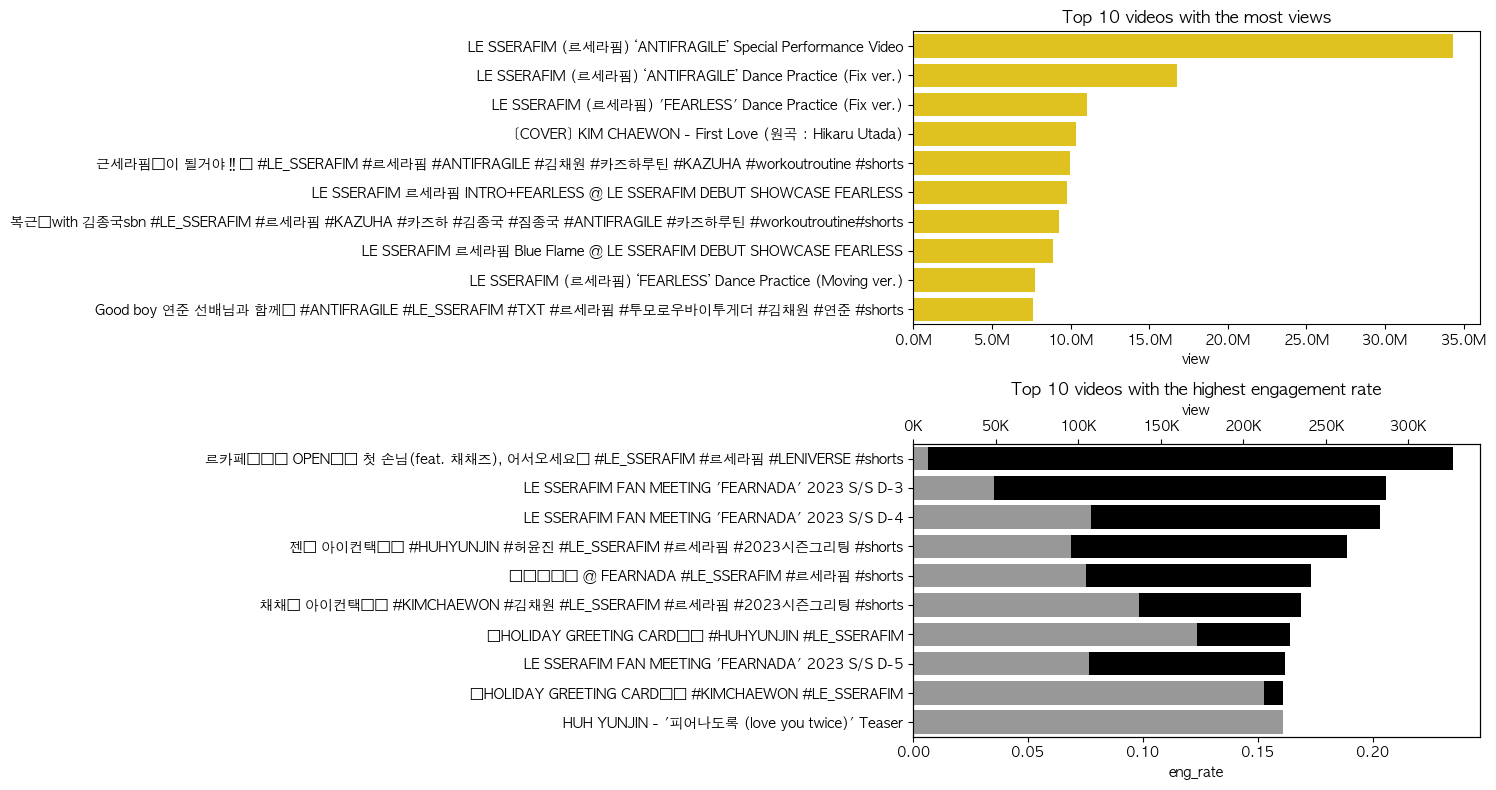

In [31]:
# Define top 10 video variables (all and excluding performance, cover related videos)
top10_view_video = video_stat.sort_values(by='view', ascending=False)[['title','view']].reset_index(drop=True).head(10)
top10_engrate_video = video_stat.sort_values(by='eng_rate', ascending=False)[['title','eng_rate','view']].reset_index(drop=True).head(10)

# Plot barplot of top 10 popular videos
f, ax = plt.subplots(2,1, figsize=(15,8))
sns.barplot(x= 'view', y= 'title', data=top10_view_video, ax=ax[0], color='gold')

sns.barplot(x= 'eng_rate', y= 'title', data=top10_engrate_video, ax=ax[1], color='black')
ax2 = ax[1].twiny()
sns.barplot(x='view', y='title', data=top10_engrate_video, ax=ax2, color='white', alpha=0.6)

# Titles for plots
ax[0].set_title('Top 10 videos with the most views',fontdict= {'fontsize': 12, 'fontweight':'bold'})
ax[1].set_title('Top 10 videos with the highest engagement rate', fontdict= {'fontsize': 12, 'fontweight':'bold'})

# Change the xaxis format to millions
ax[0].xaxis.set_major_formatter(formatter_m)
ax2.xaxis.set_major_formatter(formatter_k)

ax[0].set_ylabel('')
ax[1].set_ylabel('')
ax[0].yaxis.set

plt.tight_layout()
plt.show()

### Popular entertainment contents among fans

Among the original contents, DAYOFF, FIM-LOG, and LENIVERSE series had the highest average views per video with 1400K, 1180K, and 1050K, respectively. DAYOFF especially had a relativley high engagement rate as well, which suggests that it's the most popular content among fans.

In [32]:
# Create a count column to count the number of videos
video_stat['count'] = 1

# Query only original entertainment contents
ent_contents = video_stat.query('content_format != "COVER" and content_format !="Other"').groupby('content_format').sum()[['count','view','like','comment']]

# Add more features for analysis
ent_contents['avg_view'] = ent_contents['view'] / ent_contents['count']
ent_contents['avg_like'] = ent_contents['like'] / ent_contents['count']
ent_contents['avg_comment'] = ent_contents['comment'] / ent_contents['count']
ent_contents['eng_rate'] = ((ent_contents['like'] + ent_contents['comment']) / ent_contents['view']).round(3)

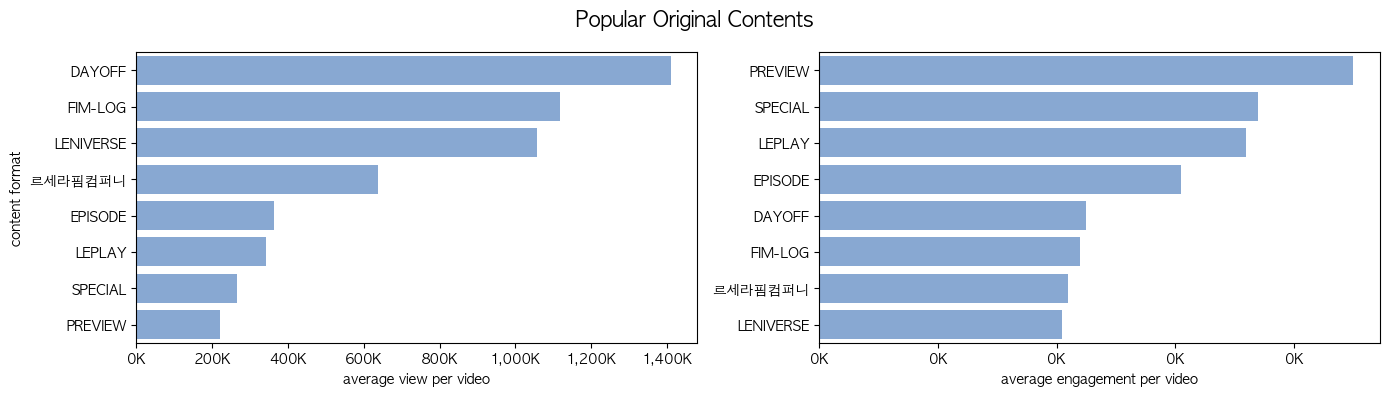

In [33]:
# Plot 2 barplots
f, ax = plt.subplots(1,2, figsize=(14,4))
ent_content_view = ent_contents.sort_values(by='avg_view', ascending=False).reset_index()
sns.barplot(x= 'avg_view', y='content_format', data=ent_content_view, color= '#7ca6de', ax=ax[0])
ent_content_engrate = ent_contents.sort_values(by='eng_rate', ascending=False).reset_index()
sns.barplot(x= 'eng_rate', y='content_format', data=ent_content_engrate, color= '#7ca6de', ax=ax[1])

# Format xaxis with formatter (thousands)
ax[0].xaxis.set_major_formatter(formatter_k)
ax[1].xaxis.set_major_formatter(formatter_k)

# Set x-axis, y-axis label
ax[0].set_xlabel('average view per video')
ax[0].set_ylabel('content format')
ax[1].set_xlabel('average engagement per video')
ax[1].set_ylabel('')

# Set the main title name
plt.suptitle('Popular Original Contents', fontsize=15, fontweight='bold')
plt.tight_layout()

The engagement rate, on average, was higher for content series with a lower-than-average view. This phenomenon is expected for YouTube videos because the lower view count suggests that only highly engaged fans watch the content, engagement rate is higher for these contents. As we can see below, the correlation between average view and engagement rate has a negative correlation of -0.81.

In [204]:
ent_contents[['avg_view','eng_rate']].corr()

,avg_view,eng_rate
avg_view,1.000000,-0.817256
eng_rate,-0.817256,1.000000


For the most popular original series, DAYOFF, FIM-LOG, LENIVERSE, I wanted to dig deeper to find out why these series are loved by fans so much. To get a clue, I listed the top 10 videos for each content series. 

- **DAYOFF**: Hard to find clues from the titles alone, but dayoff contents are filmed right after the last performance of each song or album, and the content is all about giving fimmies (Le sserafim members) a good time after their hard work. Therefore, fans might like this content because they like to watch fimmies getting rewarded after their hard work.
- **FIM-LOG**: The most popular fim-log contents are fim-logs filmed when they were in Japan. Part of it can be because they are very popular in Japan, so Japanese fans watched the video a lot, and another reason can be that vlogs filmed in another country can be appealing to fans outside of Japan as well because it can help fans travel to Japan vicariously. 
- **LENIVERSE**: The series about playing rock paper scissors in the playground, and the PC game room series did very well. These contents showed fimmies' fun side while playing games and competing with each other. 


In [35]:
# Get separate df for each original series
dayoff = video_stat.query('content_format == "DAYOFF"').sort_values(by='view', ascending=False).head(10)
fimlog = video_stat.query('content_format == "FIM-LOG"').sort_values(by='view', ascending=False).head(10)
leniverse = video_stat.query('content_format == "LENIVERSE"').sort_values(by='view', ascending=False).head(10)

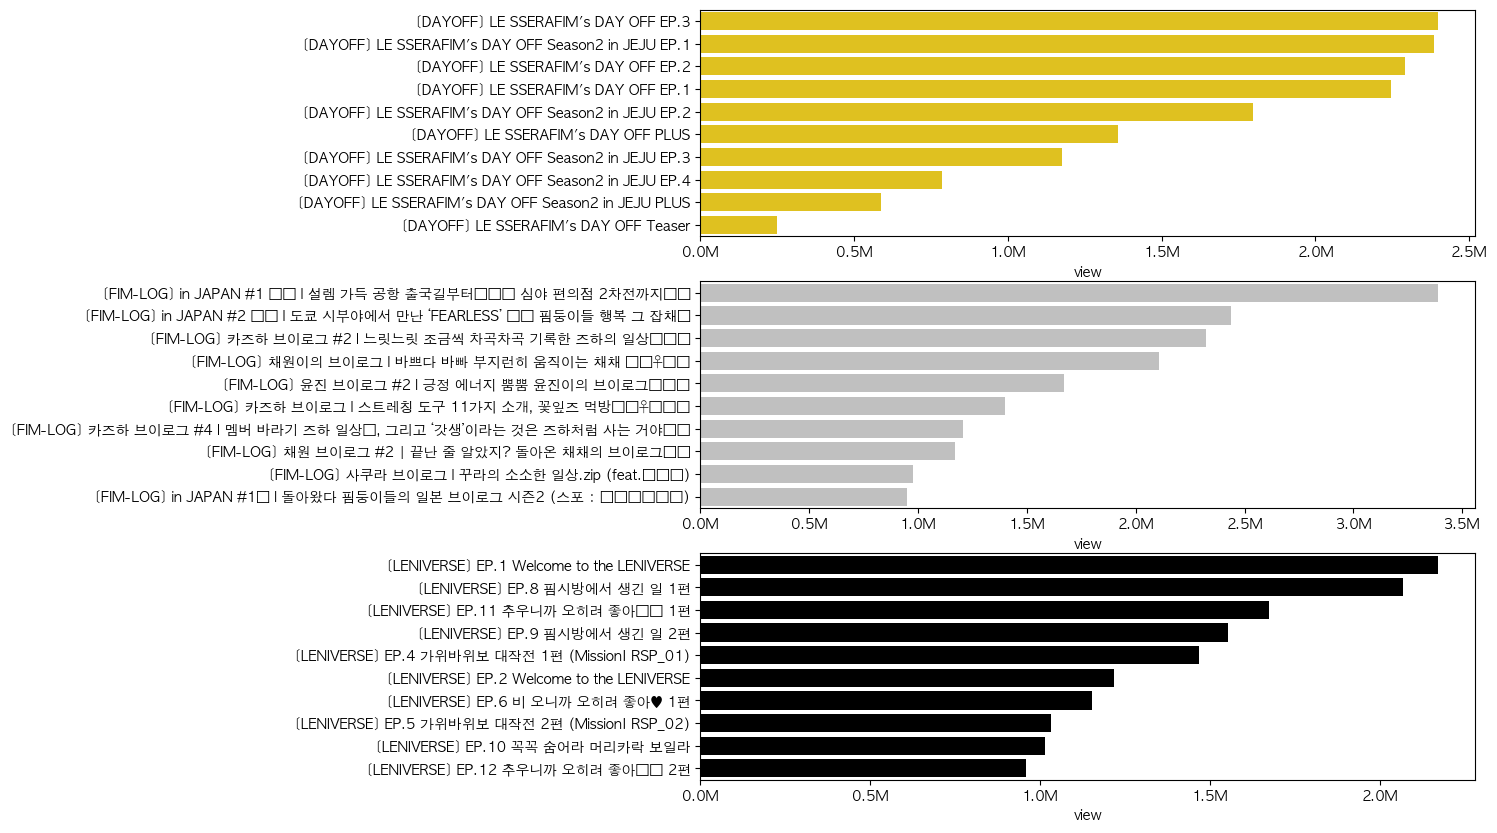

In [36]:
# Get top 10 titles for each series
f, ax = plt.subplots(3,1, figsize=(10,10))
sns.barplot(x= 'view', y= 'title', data=dayoff, ax=ax[0], color='gold')
sns.barplot(x= 'view', y= 'title', data=fimlog, ax=ax[1], color='silver')
sns.barplot(x= 'view', y= 'title', data=leniverse, ax=ax[2], color='black')

# Format x-axis value to millions
ax[0].xaxis.set_major_formatter(formatter_m)
ax[1].xaxis.set_major_formatter(formatter_m)
ax[2].xaxis.set_major_formatter(formatter_m)

# Omit y axis label
ax[0].set_ylabel('')
ax[1].set_ylabel('')
ax[2].set_ylabel('')

plt.show()

### What are some contents that did not perform relatively well?

Observing the contents that did not do well can also give us some insights. First, I looked at the top 10 videos (excluding shorts) with the least amount of views. I excluded shorts videos because shorts videos are usually used as a notification for events, content teasers, or an edited version of the VOD form so not useful in determining the performance of the content material. Also, I wanted to take the upload date into a consideration, so plotted the second bar chart with videos uploaded at least 1 month+. <br>

The top 10 videos with the least amount of views tend to be showcase video, or [LEPLAY] series that shows the work (photoshoot, video making) environment. From this result, we can infer that fans like to watch VLOG-style videos, but they want VLOGs that show the members' private life, not their working environment. Also, LEPLAY contents usually only have one or two members in the content, which makes it harder to show the chemistry between members. 

In [37]:
top10_least_view_video = video_stat.query('video_format!="Shorts"').sort_values(by='view').head(10)
top10_least_view_old_video = video_stat.query('video_format !="Shorts" and upload_date <= "2023-02-27"').sort_values(by='view').head(10)

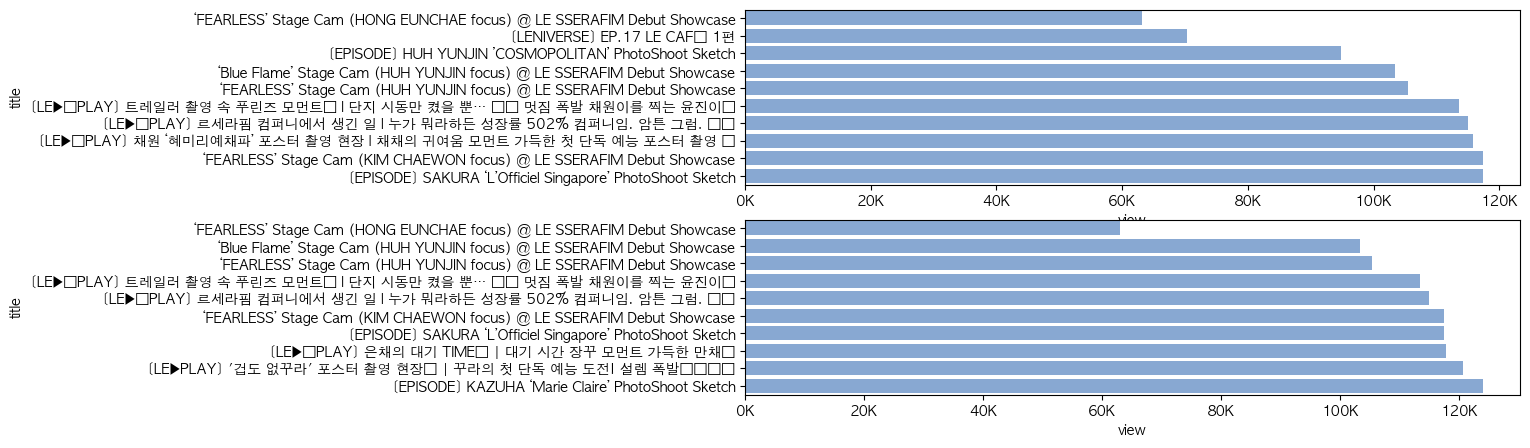

In [38]:
f, ax = plt.subplots(2,1, figsize=(10, 5))
sns.barplot(x= 'view', y= 'title', data= top10_least_view_video, color= '#7ca6de', ax=ax[0])
sns.barplot(x= 'view', y= 'title', data= top10_least_view_old_video, color= '#7ca6de', ax=ax[1])

ax[0].xaxis.set_major_formatter(formatter_k)
ax[1].xaxis.set_major_formatter(formatter_k)

### How did the content series pefrom over time?

So far, we have analyzed what type of content got the most views and engagement from the fans. However, we also have to take into account the content trends because the same content format may not be popular after a while since the audience can get tired of watching the same content format. To spot some trends over time, I excluded shorts format and created another `content_format2` column which divides the content group into "Ent"(Entertainment related) and "Non-ent" (Music, cover, performance videos, etc.) contents, and plotted time series line plot. 

In [39]:
# Exclude shorts format to spot the trends
video_stat_no_shorts = video_stat.query('video_format != "Shorts"')

# Create content_format2 that divides the content form into "ent" and "non-ent"
video_stat_no_shorts.loc[video_stat_no_shorts['content_format'].str.contains("Other|COVER|PREVIEW|SPECIAL|EPISODE"),'content_format2'] = 'non-ent'
video_stat_no_shorts['content_format2'] = video_stat_no_shorts['content_format2'].fillna('ent', axis=0)

In [40]:
# Create new varaibles to plot
content2_time_mean_metric = video_stat_no_shorts.groupby(['content_format2','year_month']).mean()[['view','like','comment']].sort_values(by='year_month').reset_index()
content2_time_sum_metric = video_stat_no_shorts.groupby(['content_format2','year_month']).sum()[['view','like','comment']].sort_values(by='year_month').reset_index()
content2_time_count = video_stat_no_shorts.groupby(['content_format2','year_month']).sum()[['view','count']].sort_values(by='year_month').reset_index()

ent_content_time_mean_metric = video_stat_no_shorts.query('content_format2 == "ent"').groupby(['content_format','year_month']).mean()[['view','like','comment']].sort_values(by='year_month').reset_index()
ent_content_time_sum_metric = video_stat_no_shorts.query('content_format2 == "ent"').groupby(['content_format','year_month']).sum()[['view','like','comment']].sort_values(by='year_month').reset_index()
ent_content_time_count = video_stat_no_shorts.query('content_format2 == "ent"').groupby(['content_format','year_month']).sum()[['view','count']].sort_values(by='year_month').reset_index()

The four plots below compare the view trends over time between music(non-ent) related content and entertainment content:
- Debut month(22 May): the highest number of contents were released this month. The main focus was non-ent/music-related content which gained the 2nd most views overall.
- Antifragile comeback month(22 Oct): The music content views exploded this month. However, the number of contents needed to achieve the result was about 50% of the debut month. 
  - 98% of the music content views came from the top 5 videos (special performance video, dance practice, music video shoot sketch)
- Entertainment contents cover the inactivity periods and helped maintain fans' interest by gaining the total views per month over 5~10M.
- There is a slight downward trend for entertainment content.

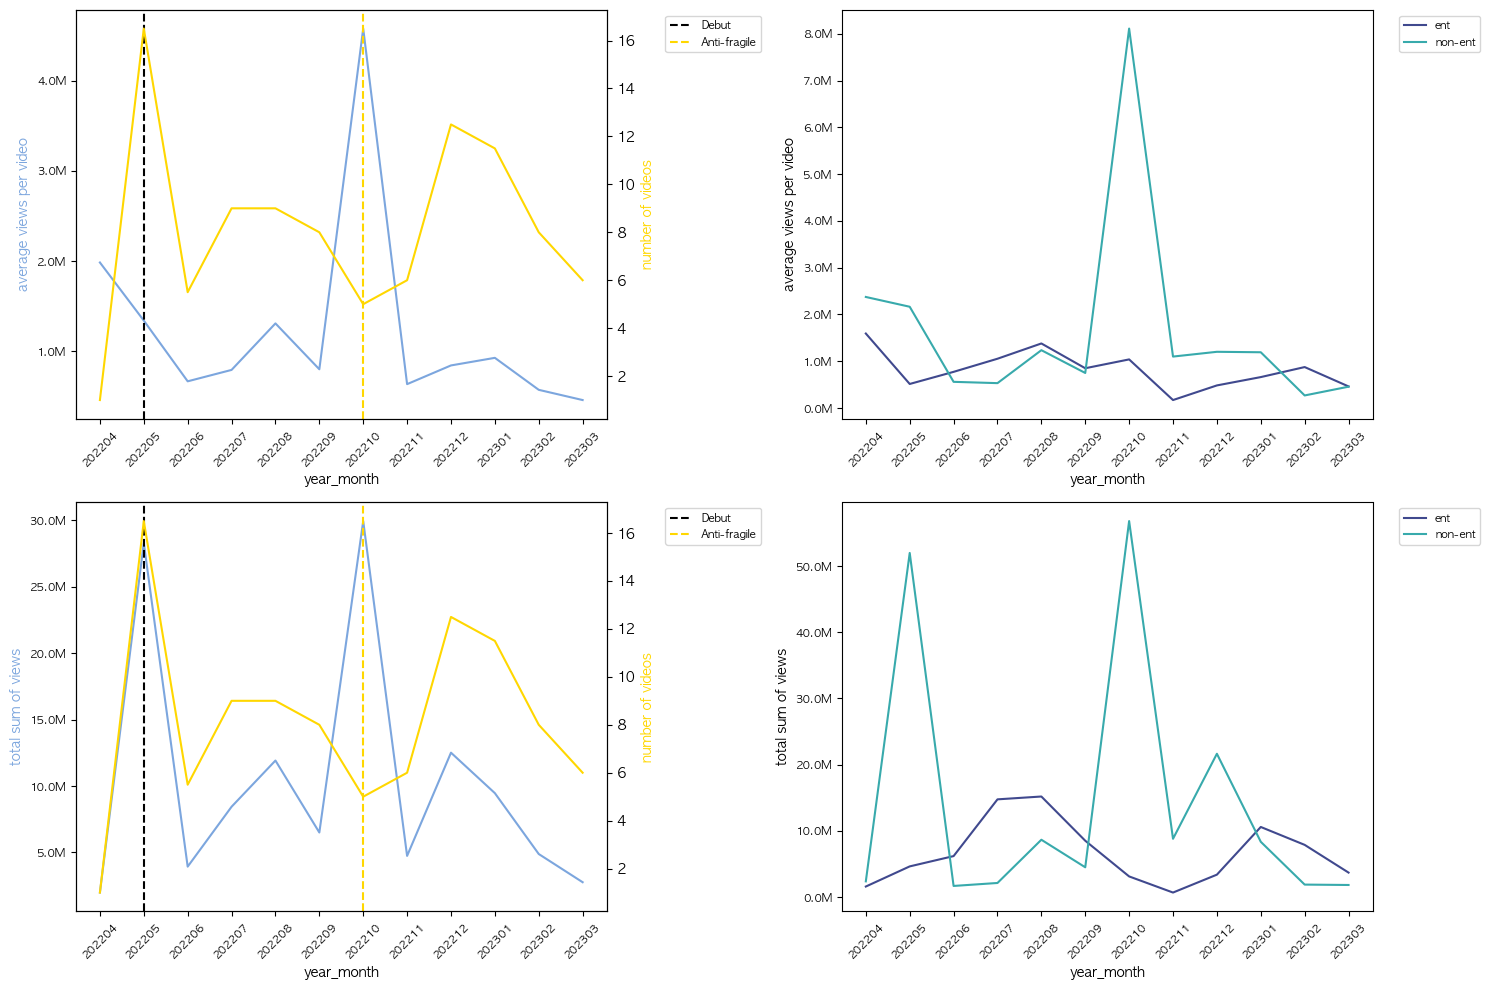

In [41]:
f, ax = plt.subplots(2,2, figsize=(15,10))
ax = ax.flatten()

# Plot the first row
sns.lineplot(x= 'year_month', y= 'view', data=content2_time_mean_metric, ax=ax[0], color='#7ca6de', ci=None)
ax2 = ax[0].twinx()

sns.lineplot(x= 'year_month', y= 'count', data=content2_time_count, ax=ax2, color='gold', ci=None)
sns.lineplot(x= 'year_month', y= 'view', data=content2_time_mean_metric, hue= 'content_format2', ax=ax[1], palette = 'mako')

# Label y axis
ax[0].set_ylabel('average views per video', color='#7ca6de')
ax2.set_ylabel('number of videos', color='gold')
ax[1].set_ylabel('average views per video')

# Rotate x axis
ax[0].set_xticklabels(ax[0].get_xticklabels(), fontsize= 8, rotation=45)
ax[0].set_yticklabels(ax[0].get_yticklabels(), fontsize= 8)
ax[1].set_xticklabels(ax[0].get_xticklabels(), fontsize= 8, rotation=45)
ax[1].set_yticklabels(ax[0].get_yticklabels(), fontsize= 8)

# Format yaxis number
ax[0].yaxis.set_major_formatter(formatter_m)
ax[1].yaxis.set_major_formatter(formatter_m)

# Draw a vertical line for major events
ax[0].axvline("202205", linestyle='--', color='black', label='Debut')
ax[0].axvline("202210", linestyle='--', color='gold', label='Anti-fragile')

# Get the legends outside the graph
ax[0].legend(bbox_to_anchor=(1.10, 1), loc="upper left", fontsize=8)
ax[1].legend(bbox_to_anchor=(1.04, 1), loc="upper left", fontsize=8)


# Plot the second row
sns.lineplot(x= 'year_month', y= 'view', data=content2_time_sum_metric, ax=ax[2], color='#7ca6de', ci=None)
ax3 = ax[2].twinx()

sns.lineplot(x= 'year_month', y= 'count', data=content2_time_count, ax=ax3, color='gold', ci=None)
sns.lineplot(x= 'year_month', y= 'view', data=content2_time_sum_metric, hue= 'content_format2', ax=ax[3], palette = 'mako')

# Label y axis
ax[2].set_ylabel('total sum of views', color='#7ca6de')
ax3.set_ylabel('number of videos', color='gold')
ax[3].set_ylabel('total sum of views')

# Rotate x axis
ax[2].set_xticklabels(ax[2].get_xticklabels(), fontsize= 8, rotation=45)
ax[2].set_yticklabels(ax[2].get_yticklabels(), fontsize= 8)
ax[3].set_xticklabels(ax[3].get_xticklabels(), fontsize= 8, rotation=45)
ax[3].set_yticklabels(ax[3].get_yticklabels(), fontsize= 8)

# Format yaxis number
ax[2].yaxis.set_major_formatter(formatter_m)
ax[3].yaxis.set_major_formatter(formatter_m)

# Draw a vertical line for major events
ax[2].axvline("202205", linestyle='--', color='black', label='Debut')
ax[2].axvline("202210", linestyle='--', color='gold', label='Anti-fragile')

# Get the legends outside the graph
ax[2].legend(bbox_to_anchor=(1.10, 1), loc="upper left", fontsize=8)
ax[3].legend(bbox_to_anchor=(1.04, 1), loc="upper left", fontsize=8)

plt.tight_layout()


In [42]:
video_stat_no_shorts.query('year_month == "202210" and content_format2=="non-ent"').sort_values(by='view', ascending=False).reset_index()[['upload_date','title','view']]

,upload_date,title,view
0,2022-10-18 14:00:02,LE SSERAFIM (르세라핌) ‘ANTIFRAGILE’ Special Perfo...,34313873
1,2022-10-20 11:00:01,LE SSERAFIM (르세라핌) ‘ANTIFRAGILE’ Dance Practic...,16765923
2,2022-10-21 10:00:01,LE SSERAFIM (르세라핌) ‘ANTIFRAGILE’ Dance Practic...,2832289
3,2022-10-23 12:00:02,LE SSERAFIM (르세라핌) 2nd Mini Album ‘ANTIFRAGILE...,1864184
4,2022-10-11 13:00:01,[EPISODE] LE SSERAFIM(르세라핌) 2nd Mini Album ‘AN...,377268
5,2022-10-04 11:00:01,[EPISODE] ANTIFRAGILE TRAILER 'The Hydra' Shoo...,369820
6,2022-10-26 08:00:03,[SPECIAL] LE SSERAFIM 'ANTIFRAGILE' 라춘댄스 react...,266026


I wanted to dig deeper into the slight downward trend of entertainment content and find out why the total view decreased over time. I plotted similar line plots, but this time with only entertainment contents and selecting `content form` as the hue parameter.<br>
From further analysis, I noticed the followings:
- LEPLAY contents have lost momentum, mainly due to the lack of reaction videos (fearless MV, fearless trailer). In 2022-05, two reaction videos had 57% of the total views that month
- FIM-LOG contents had the most views in 2022-08 when the two Japan VLOG contents exploded with each 3.3M, and 2.4M views. The recent Japan VLOG content is also doing well (uploaded in March, already almost reaching 1M)
- There were no DAYOFF or 르세라핌컴퍼니 contents for the past two months. DAYOFF contents are understandable since it's a special series filmed right after the album activity's finale. 르세라핌컴퍼니 content, however, is absent at the moment. Maybe new content can replace this series since the average view is lower than other popular original series.  

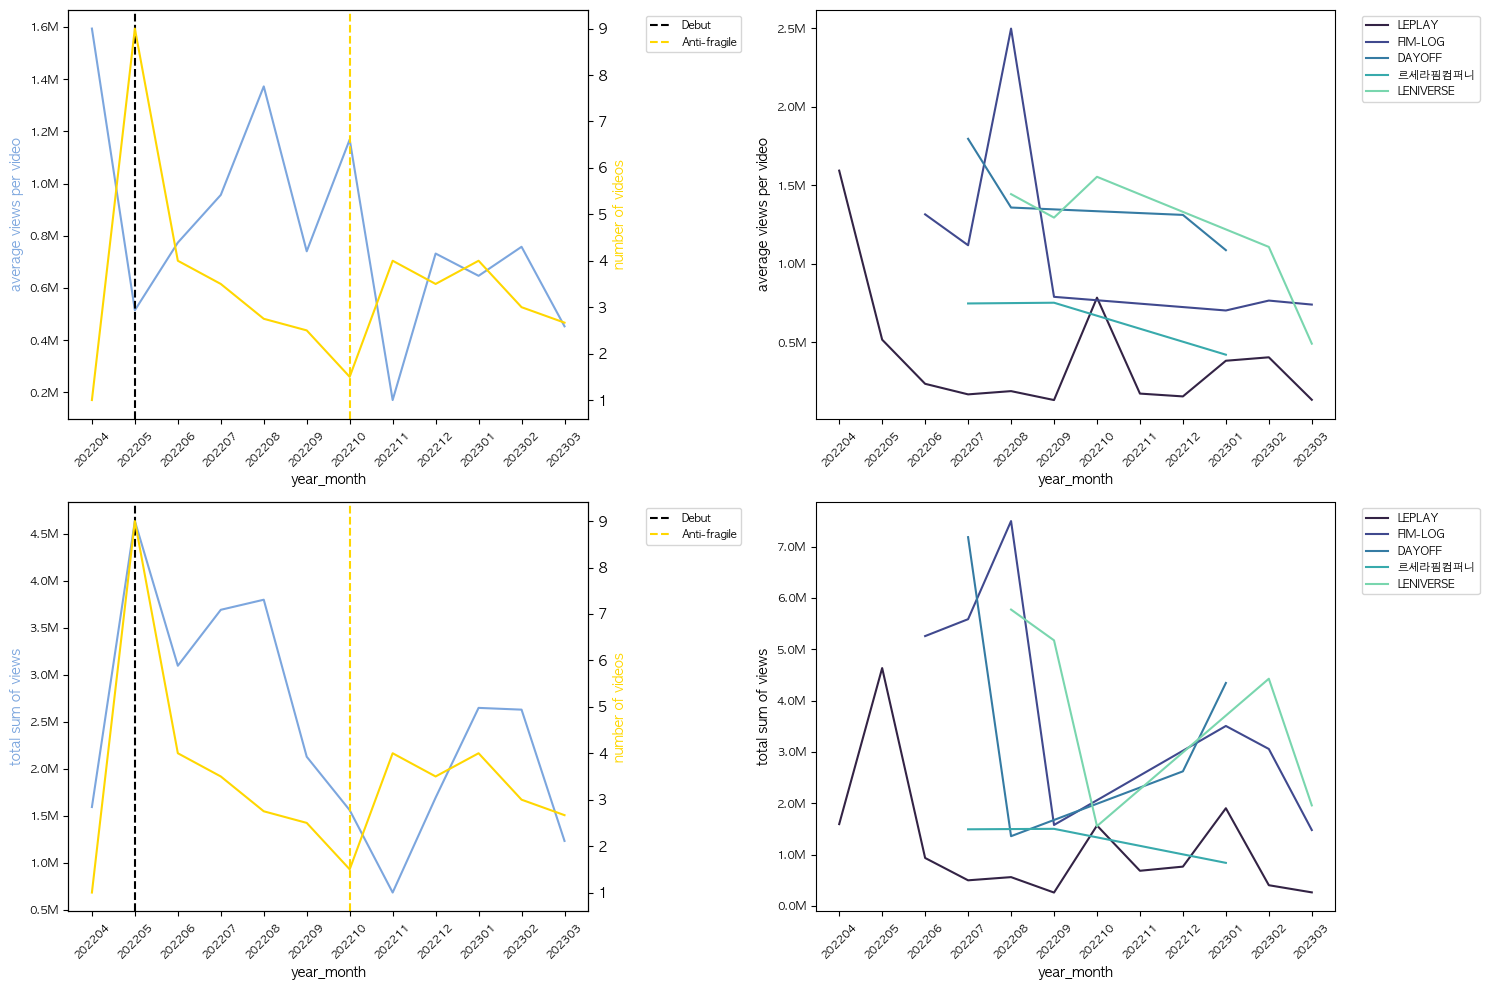

In [43]:
# Create new dataframe to graph
ent_content_time_mean_metric = video_stat_no_shorts.query('content_format2 == "ent"').groupby(['content_format','year_month']).mean()[['view','like','comment']].sort_values(by='year_month').reset_index()
ent_content_time_sum_metric = video_stat_no_shorts.query('content_format2 == "ent"').groupby(['content_format','year_month']).sum()[['view','like','comment']].sort_values(by='year_month').reset_index()
ent_content_time_count = video_stat_no_shorts.query('content_format2 == "ent"').groupby(['content_format','year_month']).sum()[['view','count']].sort_values(by='year_month').reset_index()

f, ax = plt.subplots(2,2, figsize=(15,10))
ax = ax.flatten()

# Plot the first row
sns.lineplot(x= 'year_month', y= 'view', data=ent_content_time_mean_metric, ax=ax[0], color='#7ca6de', ci=None)
ax2 = ax[0].twinx()

sns.lineplot(x= 'year_month', y= 'count', data=ent_content_time_count, ax=ax2, color='gold', ci=None)
sns.lineplot(x= 'year_month', y= 'view', data=ent_content_time_mean_metric, hue= 'content_format', ax=ax[1], palette = 'mako')

# Label y axis
ax[0].set_ylabel('average views per video', color='#7ca6de')
ax2.set_ylabel('number of videos', color='gold')
ax[1].set_ylabel('average views per video')

# Rotate x axis
ax[0].set_xticklabels(ax[0].get_xticklabels(), fontsize= 8, rotation=45)
ax[0].set_yticklabels(ax[0].get_yticklabels(), fontsize= 8)
ax[1].set_xticklabels(ax[0].get_xticklabels(), fontsize= 8, rotation=45)
ax[1].set_yticklabels(ax[0].get_yticklabels(), fontsize= 8)

# Format yaxis number
ax[0].yaxis.set_major_formatter(formatter_m)
ax[1].yaxis.set_major_formatter(formatter_m)

# Draw a vertical line for major events
ax[0].axvline("202205", linestyle='--', color='black', label='Debut')
ax[0].axvline("202210", linestyle='--', color='gold', label='Anti-fragile')

# Get the legends outside the graph
ax[0].legend(bbox_to_anchor=(1.10, 1), loc="upper left", fontsize=8)
ax[1].legend(bbox_to_anchor=(1.04, 1), loc="upper left", fontsize=8)


# Plot the second row
sns.lineplot(x= 'year_month', y= 'view', data=ent_content_time_sum_metric, ax=ax[2], color='#7ca6de', ci=None)
ax3 = ax[2].twinx()

sns.lineplot(x= 'year_month', y= 'count', data=ent_content_time_count, ax=ax3, color='gold', ci=None)
sns.lineplot(x= 'year_month', y= 'view', data=ent_content_time_sum_metric, hue= 'content_format', ax=ax[3], palette = 'mako')

# Label y axis
ax[2].set_ylabel('total sum of views', color='#7ca6de')
ax3.set_ylabel('number of videos', color='gold')
ax[3].set_ylabel('total sum of views')

# Rotate x axis
ax[2].set_xticklabels(ax[2].get_xticklabels(), fontsize= 8, rotation=45)
ax[2].set_yticklabels(ax[2].get_yticklabels(), fontsize= 8)
ax[3].set_xticklabels(ax[3].get_xticklabels(), fontsize= 8, rotation=45)
ax[3].set_yticklabels(ax[3].get_yticklabels(), fontsize= 8)

# Format yaxis number
ax[2].yaxis.set_major_formatter(formatter_m)
ax[3].yaxis.set_major_formatter(formatter_m)

# Draw a vertical line for major events
ax[2].axvline("202205", linestyle='--', color='black', label='Debut')
ax[2].axvline("202210", linestyle='--', color='gold', label='Anti-fragile')

# Get the legends outside the graph
ax[2].legend(bbox_to_anchor=(1.10, 1), loc="upper left", fontsize=8)
ax[3].legend(bbox_to_anchor=(1.04, 1), loc="upper left", fontsize=8)

plt.tight_layout()

In [44]:
# Percentage of 2 reaction videos' views / total videos' views for 202205
(video_stat_no_shorts.query('content_format2 == "ent" and year_month=="202205"').sort_values(by='view', ascending=False)[0:2].sum()['view']\
 /video_stat_no_shorts.query('content_format2 == "ent" and year_month=="202205"').sort_values(by='view', ascending=False).sum()['view']).round(3)

0.572

In [45]:
# Views for MBTI related contents
video_stat_no_shorts.query('title.str.contains("MBTI")').sort_values(by='view', ascending=False).head(10)

,video_id,upload_date,title,description,duration,view,like,comment,year,month,year_month,eng_rate,content_format,video_format,promotion,count,content_format2
311,FppXmnfeMVE,2022-05-03 13:00:01,FIMBTI #1 l 눈 떠보니 내가 동물이라고? 🐯🐱🐿,#LE_SSERAFIM #르세라핌 공식 채널\n#LE_SSERAFIM #르세라핌 O...,0 days 00:15:24,997526,60949,2309,2022,5,202205,0.063,Other,VOD,False,1,non-ent
307,rX95GvQ0BF8,2022-05-05 03:00:01,FIMBTI #2 l 그런 생각을 한다고..?! 상상력이 어디까지 가는 거예↗️요?,#LE_SSERAFIM #르세라핌 공식 채널\n#LE_SSERAFIM #르세라핌 O...,0 days 00:14:51,645413,36943,1516,2022,5,202205,0.060,Other,VOD,False,1,non-ent


### Wordcloud for words in comments

For different content formats, I wanted to explore video comments by creating a wordcloud image for each content format. First, I compared the wordcloud between non-entertainment and
entertainment content. Then, also looked for interesting differences between each entertainment content format, and other(music) content. (excluded basic name-related keywords) <br>

First, I created content_format2 for comments dataframe.

In [48]:
# Create content_format2 column with 'non-ent', and 'ent'
comments.loc[comments['content_format'].isin(['Other','Cover','PREVIEW','SPECIAL','EPISODE']), 'content_format2'] = 'non-ent'
comments['content_format2'] = comments['content_format2'].fillna('ent')

# non-ent contents
non_ent = comments.query('content_format2 == "non-ent"')
# ent contents
ent = comments.query('content_format2 == "ent"')

Then, I plotted two wordcloud images that show popular comment keywords for non-entertainment contents and entertainment contents.

The wordcloud image comparison illustrated the followings:
- Some of the keywords that stood out in non-entertainment-related videos are: "Pretty, Cute, Dance, Visual, talented, queen, proud, featnot"
    - We can predict that fans think fimmies are pretty and cute visual queens, with talented dance moves and voice.\Also, they are proud to be fearnot.
- Some of the keywords that stood out in entertainment videos are: "cute, funny, adorable, baby, maknae"
    - We can see that, unlike the music-related videos, fans love Le sserafim's more fun, adorable side of their personalities, and relationship. There's also a focus on maknae(baby) or Eunchae who is loved by members and fans alike.

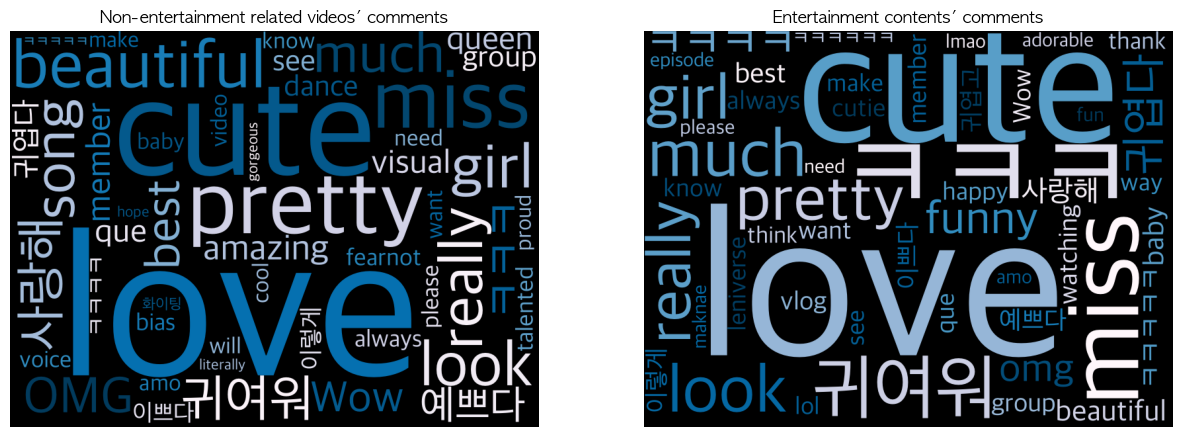

In [49]:
# Show all the comments
pd.set_option('display.max_rows', None)

# Add keywords to exclude
stopwords = set(STOPWORDS)
my_stopwords = ['Yunjin','Eunchae','즈하','채원','김채원','은채','카즈하','Kazuha','Chaewon','Kim Garam','garam','Sakura','Garam','Kkura','윤진이','허윤진','사쿠라','Zuha','manchae','만채','채원이','꾸라'\
               'will','back','day','one','HUH','Kim','sserafim','르세라핌','Lesserafim','lesserafim']
stopwords.update(my_stopwords)

font_path = "/System/LIbrary/Fonts/Supplemental/AppleSDGothicNeo.ttc"

f, ax = plt.subplots(1,2, figsize=(15,8))

# Create two WordCloud
wordcloud1 = WordCloud(stopwords=stopwords, background_color='black', width=800, height=600, font_path=font_path, colormap = 'PuBu',max_words=50, min_word_length=3)\
            .generate(str(non_ent['comment_detail']))
wordcloud2 = WordCloud(stopwords=stopwords, background_color='black', width=800, height=600, font_path=font_path, colormap = 'PuBu',max_words=50, min_word_length=3)\
            .generate(str(ent['comment_detail']))

# Plot the first wordcloud in the first subplot
ax[0].imshow(wordcloud1)
ax[0].set_title('Non-entertainment related videos\' comments')

# Plot the second wordcloud in the second subplot
ax[1].imshow(wordcloud2)
ax[1].set_title('Entertainment contents\' comments')


ax[0].axis('off')
ax[1].axis('off')

plt.show()

Additionally, I plotted the wordclouds for 'Other', 'DAYOFF', 'FIM-LOG', 'LENIVERSE' content formats. This time, I excluded basic names, and basic emotion (love, cute, pretty) keywords as well:

- Music: Interesting keywords include "best, slay, song, dance, visual, queen, girl, group"
    - Similar to what we witnessed in the above non-entertainment videos, fans' reactions focus on Le sserafim's dance performance, songs, and visuals. 
- DAYOFF: Top keywords include "really, happy, laugh, fimmies, excited, jeju, hybe"
    - DAYOFF contents give fimmies time to rest and have fun. Fans are happy to see them have fun and have cute interactions with each other. Also, many fans praise Hybe for giving Le sserafim a wonderful vacation.
- FIM-LOG: Top keywords include "baby, maknae, 김치찌개(kimchi soup), 한국어/한국말 하는거(speaking Korean), members, kawai (cute in japanese)"
    - In Fimlog content, fans enjoy getting to know the personal side of the members. They mention cute baby maknae Eunchae a lot, and little details like how much Sakura likes kimchi soup, or how much Kazuha's Korean skill has improved.
    - It's also worth noting that for the first time, Japanese word for cute became the top keyword. (Thanks to Japan Vlog contents)
- LENIVERSE: Top keywords include "game, episode, reaction, best, ㅋㅋㅋㅋ (lol)"
    - Leniverse is about playing games, so fans like the interaction between members as they compete in the game. 
    - This content format had the most 'ㅋㅋㅋ' (which is lol in Korean), meaning many fans thought Leniverse episodes were very fun. 
    

In [52]:
# Create variables for each content format
music_com = comments.query('content_format == "Other"')
dayoff_com = comments.query('content_format == "DAYOFF"')
fimlog_com = comments.query('content_format == "FIM-LOG"')
leniverse_com = comments.query('content_format == "LENIVERSE"')

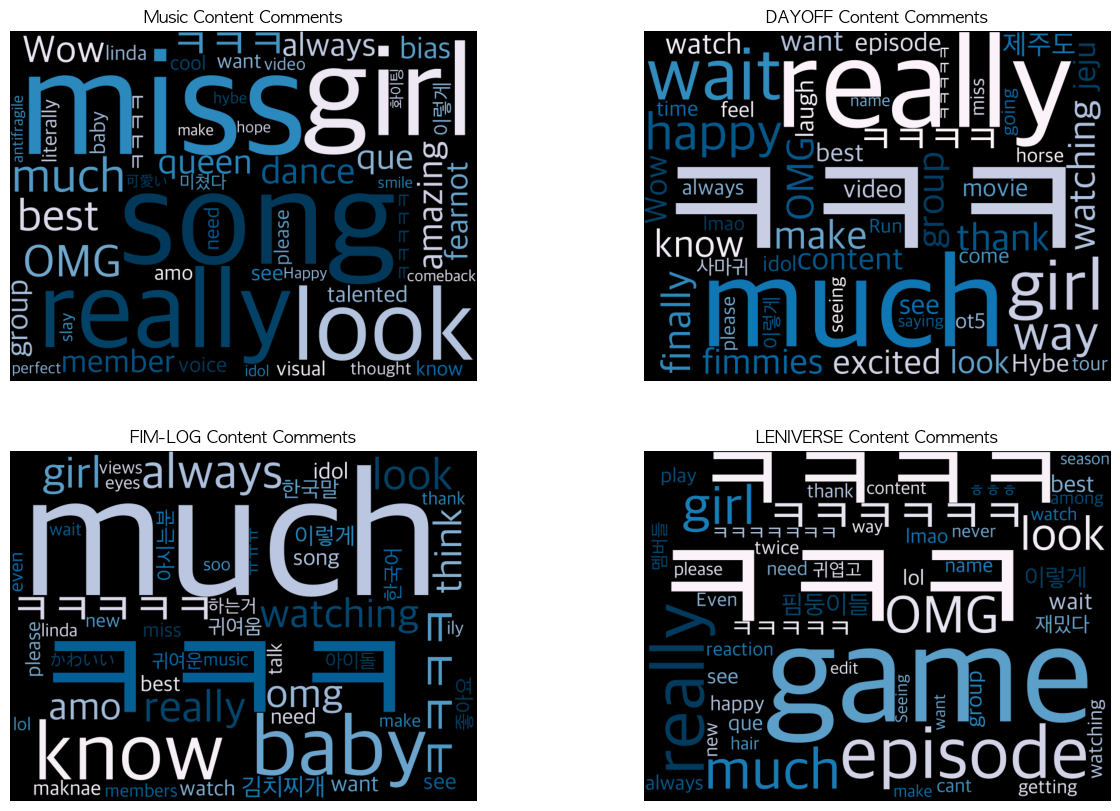

In [53]:
# Show all the comments
pd.set_option('display.max_rows', None)

# Add keywords to exclude
stopwords = set(STOPWORDS)
my_stopwords = ['Yunjin','Eunchae','즈하','채원','김채원','은채','카즈하','Kazuha','Chaewon','Kim Garam','garam','Sakura','Garam','Kkura','윤진이','허윤진','사쿠라','Zuha','manchae','만채','채원이','꾸라','르세라핌은',\
               'will','back','day','one','HUH','Kim','sserafim','SSERAFIM','르세라핌','lesserafim','은채야','카즈하는','꾸라가','은채가','leniverse','브이로그','vlog','데이오프','르니버스','데이오프','Leniverse',
               'love','beautiful','pretty','cute','사랑해','귀여워','이쁘다','예쁘다','귀엽다','사랑해요','funny','fun','이쁘고','예쁘고','vlogs']
stopwords.update(my_stopwords)

# Choosing specific font for wordcloud 
font_path = "/System/LIbrary/Fonts/Supplemental/AppleSDGothicNeo.ttc"

f, ax = plt.subplots(2,2, figsize=(15,10))

ax = ax.flatten()

wc_list = [music_com, dayoff_com, fimlog_com, leniverse_com]
wc_title = ["Music Content", "DAYOFF Content", "FIM-LOG Content", "LENIVERSE Content"]

# Create multiple wordcloud
wordcloud_list = [WordCloud(stopwords=stopwords, background_color='black', width=800, height=600, font_path=font_path, colormap = 'PuBu',max_words=50, min_word_length=3)\
            .generate(str(wc['comment_detail'])) for wc in wc_list]

for i, wc2 in enumerate (wordcloud_list):
    # Plot the first wordcloud in the first subplot
    ax[i].imshow(wc2)
    ax[i].set_title(f'{wc_title[i]} Comments')
    # Turn off the axis
    ax[i].axis('off')

plt.show()

In [70]:
# Only one video from the VOD contents had promotion keywords in the video. 
comments.loc[comments['promotion']==True, 'video_id'].unique()

array(['aO92SlPwIcQ'], dtype=object)

# 5. Conclusions

In this project, we have explored the K-pop group Le sserafim's YouTube channel data by using the YouTube API data to obtain video statistics and top 100 comments data for each video. The analysis of the data demonstrated some interesting findings about the Le sserafim YouTube channel's performance:

- The most popular videos for Le sserafim channel were dance performance videos. Not surprising since the group is known for delivering great dance performances. (Music videos are excluded since they are uploaded on the HYBE channel)
- The second most popular videos were about showcasing their passion for exercise. 
- Among the entertainment contents, DAYOFF, FIM-LOG, and LENIVERSE performed particularly well. DAYOFF content was focused on giving a good time for fimmies which in turn made fans happy. Fimlogs portrayed the aspect of their private life, and Leniverse showed their competitive and mischievous spirits. 
- The comment section also corroborates the points made before:
    - DAYOFF: Fans are happy that the company (Hybe / Source Music) is giving fimmies great experiences like a trip to Jeju.
    - FIMLOG: Fans comment about trivial traits of each member. They like to know these little things about them, which makes them more relatable.
    - LENIVERSE: Fans laugh the most on Leniverse videos. They love mischievous and competitive fimmies.
- The entertainment content helped maintain the overall view of the channel during the non-activity period. However, there is a slight downward trend in views for entertainment content
- The downward trend is mainly due to LEPLAY content's poor performance and the lack of hero content like DAYOFF series. 

#### New Content Ideation

Considering the findings above, I came up with some ideas about new content for the channel. 

Before suggesting any new content, I want to point out that it's hard to produce many different types of content, especially, if there is a budget constraint. I think it would be best to stop 르세라핌컴퍼니 content series and LEPLAY content since they are less popular than other top 3 entertainment contents. <br>

Here are some ideas about each content format:

- **LEPLAY**: Most of LEPLAY content is not performing well, but reaction videos got many views. Fans are curious about how Le sserafim themselves react to their music videos. On top of that, maybe it would be nice to expand this reaction format and react to fans' dance cover of Le sserafim songs or fans' dance challenge videos which can be a great interaction between fans and fimmies, and get great engagement from fans.
- **DAYOFF**: Dayoff contents are popular and also helps with the company's image. However, since the production cost is relatively high for this format, it would be nice to sell more ads for this type of content. I noticed a few PPLs for the content(not found in the description but has a promotion banner), but it would be nice to incorporate ppl more and use that budget to visit exotic places or the home of each member. (Osaka, Kagoshima, New York)
- **FIM-LOG**: Japan Vlogs are the most popular fimlog content. It's satisfying to watch fimmies have fun in other countries. As they gain more opportunities to perform outside of Korea, it would be nice to make more FIM-LOGs in various countries. 
- **New_series**: During the Covid era, zoom discussion content was pretty successful considering the low budget. It doesn't have to be a zoom format, but maybe having silly discussions about certain topics can be entertaining as well. Since fimmies are into MBTI, MBTI-related discussions can spark great discussion as well. They did two MBTI-related videos before and both did pretty well (600K+, 900K+ views)

#### Project limitations

The findings illustrate some interesting points but have limitations for several reasons:
- The video statistics are total metrics so we cannot compare the view and engagement that occurred for the same amount of time. (7-day, 14-day period)
- There are only 100 comments for each video, so it doesn't capture all the reactions from fans.
- It's not possible to detect promotion banners using the API, so it's hard to know exactly how many videos had promotions. (PPL)

#### Ideas for further research

To further the research, one can:
- Expand the dataset to include other popular 4th gen K-pop girl group channel data. (New Jeans, Ive, Kepler, NMIXX)
- Use web-scraping to get all the comments for each video.
- Use web-scraping to check whether the video has a promotion banner.